In [1]:
import numpy as np
import pyvista
import ufl
from dolfinx import default_scalar_type, fem, mesh, plot
from dolfinx.fem import petsc
from mpi4py import MPI

In [2]:
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)
V = fem.functionspace(domain, ("Lagrange", 1))

In [3]:
uD = fem.Function(V)
uD.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [4]:
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
f = fem.Constant(domain, default_scalar_type(-6))
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

In [5]:
problem = petsc.LinearProblem(
    a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
uh = problem.solve()

In [6]:
V2 = fem.functionspace(domain, ("Lagrange", 2))
uex = fem.Function(V2)
uex.interpolate(lambda x: 1 + x[0] ** 2 + 2 * x[1] ** 2)
L2_error = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2 = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))
error_max = np.max(np.abs(uD.x.array - uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_L2 : 8.24e-03
Error_max : 3.55e-15


In [7]:
print(pyvista.global_theme.jupyter_backend)

trame


In [8]:
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")

(<FieldAssociation.POINT: 0>,
 pyvista_ndarray([1.      , 1.03125 , 1.015625, 1.046875, 1.125   ,
                  1.140625, 1.0625  , 1.09375 , 1.28125 , 1.296875,
                  1.1875  , 1.140625, 1.171875, 1.5     , 1.515625,
                  1.34375 , 1.265625, 1.25    , 1.28125 , 1.78125 ,
                  1.796875, 1.5625  , 1.421875, 1.375   , 1.390625,
                  1.421875, 2.125   , 2.140625, 1.84375 , 1.640625,
                  1.53125 , 1.515625, 1.5625  , 1.59375 , 2.53125 ,
                  2.546875, 2.1875  , 1.921875, 1.75    , 1.671875,
                  1.6875  , 1.765625, 1.796875, 3.      , 3.015625,
                  2.59375 , 2.265625, 2.03125 , 1.890625, 1.84375 ,
                  1.890625, 2.      , 2.03125 , 3.0625  , 2.671875,
                  2.375   , 2.171875, 2.0625  , 2.046875, 2.125   ,
                  3.140625, 2.78125 , 2.515625, 2.34375 , 2.265625,
                  2.28125 , 3.25    , 2.921875, 2.6875  , 2.546875,
                  

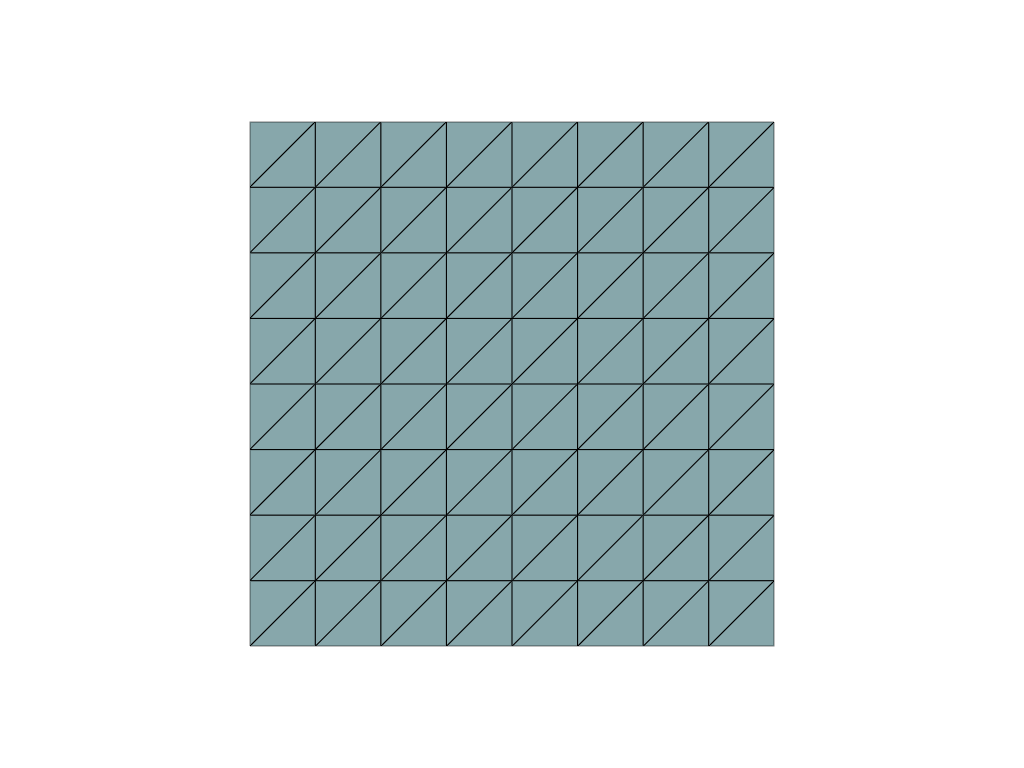

In [12]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()

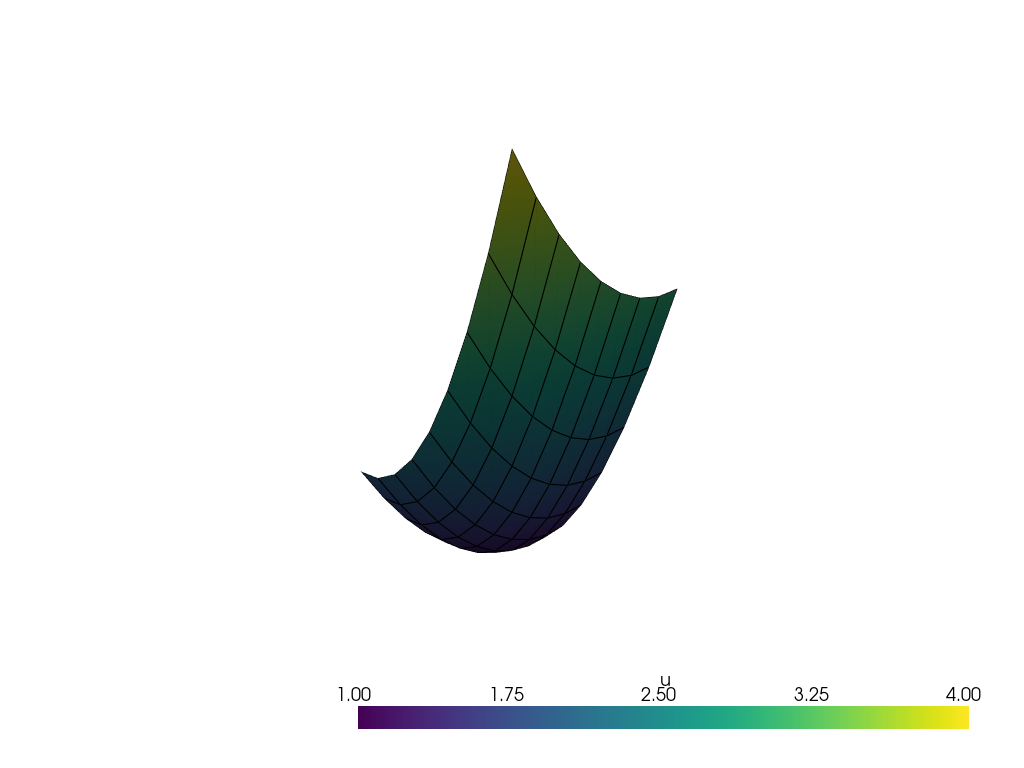

In [13]:
warped = u_grid.warp_by_scalar()
plotter2 = pyvista.Plotter()
plotter2.add_mesh(warped, show_edges=True, show_scalar_bar=True)
plotter2.show()